In [50]:

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, BaseMessage
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.sqlite import SqliteSaver
import json
from typing import TypedDict, Literal, Optional, List, Dict, Any, Annotated
from langgraph.graph.message import add_messages

import re
import sqlite3

In [31]:

class AgentState(TypedDict):
    """State passed between agents in the workflow"""
    query: str
    query_type: Optional[Literal["STRUCTURED", "SEMANTIC", "HYBRID"]]
    routing_reasoning: Optional[str]

    # Structured query results
    sql_query: Optional[str]
    sql_results: Optional[Dict[str, Any]]
    sql_error: Optional[str]

    # Semantic search results
    semantic_query: Optional[str]
    semantic_results: Optional[Dict[str, Any]]
    semantic_error: Optional[str]

    # Final output
    final_response: str
    error: Optional[str]


In [32]:

def get_llm():
    """Get configured LLM instance"""
    if not OPENAI_API_KEY:
        raise ValueError("OPENAI_API_KEY not set in environment")

    return ChatOpenAI(
        model=LLM_MODEL,
        temperature=0,
        openai_api_key=OPENAI_API_KEY
    )


In [33]:
def router_agent(state: AgentState) -> AgentState:
    """
    Route query to appropriate agent(s)
    Classifies query as STRUCTURED, SEMANTIC, or HYBRID
    """
    query = state["query"]

    try:
        llm = get_llm()
        prompts = format_router_prompt(query)

        messages = [
            SystemMessage(content=prompts["system"]),
            HumanMessage(content=prompts["user"])
        ]

        response = llm.invoke(messages)
        content = response.content

        # Extract query type from response
        query_type = None
        if "STRUCTURED" in content.upper():
            query_type = "STRUCTURED"
        elif "SEMANTIC" in content.upper():
            query_type = "SEMANTIC"
        elif "HYBRID" in content.upper():
            query_type = "HYBRID"
        elif "GENERAL" in content.upper():
            query_type = "GENERAL"
        else:
            # Default to STRUCTURED if unclear
            query_type = "GENERAL"

        state["query_type"] = query_type
        state["routing_reasoning"] = content

        print(f"\n[ROUTER] Classified as: {query_type}")
        print(f"[ROUTER] Reasoning: {content[:200]}...")

    except Exception as e:
        print(f"[ROUTER ERROR] {e}")
        state["query_type"] = "STRUCTURED"  # Default fallback
        state["error"] = f"Router error: {e}"

    return state

In [34]:
def structured_query_agent(state: AgentState) -> AgentState:
    """
    Generate and execute SQL queries for structured data
    """
    query = state["query"]

    try:
        # Get database tool and schema
        db_tool = get_duckdb_tool()
        schema = db_tool.get_schema()

        # Generate SQL query
        llm = get_llm()
        prompts = format_structured_query_prompt(query, schema)

        messages = [
            SystemMessage(content=prompts["system"]),
            HumanMessage(content=prompts["user"])
        ]

        response = llm.invoke(messages)
        sql_query = response.content.strip()

        # Extract SQL from code blocks if present
        sql_match = re.search(r'```sql\n(.*?)\n```', sql_query, re.DOTALL)
        if sql_match:
            sql_query = sql_match.group(1)
        elif '```' in sql_query:
            # Remove any code block markers
            sql_query = sql_query.replace(
                '```sql', '').replace('```', '').strip()

        state["sql_query"] = sql_query
        print(f"\n[STRUCTURED] Generated SQL:\n{sql_query}")

        # Execute query
        result = db_tool.execute_query(sql_query)

        if result["success"]:
            state["sql_results"] = result
            print(f"[STRUCTURED] Found {result['row_count']} results")
        else:
            state["sql_error"] = result["error"]
            print(f"[STRUCTURED ERROR] {result['error']}")

    except Exception as e:
        print(f"[STRUCTURED ERROR] {e}")
        state["sql_error"] = str(e)

    return state


In [35]:
def rag_agent(state: AgentState) -> AgentState:
    """
    Perform semantic search on movie overviews
    """
    query = state["query"]

    try:
        # Get ChromaDB tool
        chroma_tool = get_chromadb_tool()

        # Generate semantic search query
        llm = get_llm()
        prompts = format_rag_query_prompt(query)

        messages = [
            SystemMessage(content=prompts["system"]),
            HumanMessage(content=prompts["user"])
        ]

        response = llm.invoke(messages)
        search_strategy = response.content

        # Extract search query (simplified - use full response as query)
        # In production, would parse the structured output more carefully
        search_query = query  # Use original query for now

        state["semantic_query"] = search_query
        print(f"\n[RAG] Search strategy:\n{search_strategy[:200]}...")

        # For HYBRID queries, check if we have SQL results to filter by
        where_filter = None
        if state["query_type"] == "HYBRID" and state.get("sql_results"):
            # Could implement metadata filtering here based on SQL results
            # For now, just do semantic search
            pass

        # Perform search
        result = chroma_tool.search(
            query=search_query,
            n_results=10,
            where_filter=where_filter
        )

        if result["success"]:
            state["semantic_results"] = result
            print(f"[RAG] Found {result['count']} results")
        else:
            state["semantic_error"] = result["error"]
            print(f"[RAG ERROR] {result['error']}")

    except Exception as e:
        print(f"[RAG ERROR] {e}")
        state["semantic_error"] = str(e)

    return state

In [36]:

def synthesizer_agent(state: AgentState) -> AgentState:
    """
    Synthesize results from structured and/or semantic queries
    Generate final conversational response
    """
    query = state["query"]

    try:
        # Prepare results summary
        sql_results_str = "No structured results"
        if state.get("sql_results") and state["sql_results"].get("success"):
            data = state["sql_results"]["data"]
            if data:
                sql_results_str = f"Found {len(data)} results:\n{json.dumps(data[:10], indent=2)}"
            else:
                sql_results_str = "Query executed successfully but returned no results"
        elif state.get("sql_error"):
            sql_results_str = f"SQL Error: {state['sql_error']}"

        semantic_results_str = "No semantic search results"
        if state.get("semantic_results") and state["semantic_results"].get("success"):
            movies = state["semantic_results"]["movies"]
            if movies:
                semantic_results_str = f"Found {len(movies)} relevant movies:\n"
                for i, movie in enumerate(movies[:5], 1):
                    meta = movie['metadata']
                    semantic_results_str += f"\n{i}. {meta.get('Series_Title', 'Unknown')} ({meta.get('Released_Year', 'N/A')})\n"
                    semantic_results_str += f"   Overview: {meta.get('Overview', 'N/A')[:150]}...\n"
            else:
                semantic_results_str = "Search completed but found no relevant results"
        elif state.get("semantic_error"):
            semantic_results_str = f"Semantic Search Error: {state['semantic_error']}"

        # Generate response
        llm = get_llm()
        prompts = format_synthesizer_prompt(
            query, sql_results_str, semantic_results_str)

        messages = [
            SystemMessage(content=prompts["system"]),
            HumanMessage(content=prompts["user"])
        ]

        response = llm.invoke(messages)
        final_response = response.content

        state["final_response"] = final_response
        print(
            f"\n[SYNTHESIZER] Generated response ({len(final_response)} chars)")

    except Exception as e:
        print(f"[SYNTHESIZER ERROR] {e}")
        state["final_response"] = f"I encountered an error generating the response: {e}"
        state["error"] = str(e)

    return state

In [51]:
# STATE DEFINITION
class AgentState(TypedDict):
    """State passed between agents in the workflow"""
    query: str
    query_type: Optional[Literal["SQL",
                                 "SEMANTIC", "HYBRID", "GENERAL"]]
    routing_reasoning: Optional[str]
    messages: Annotated[List[BaseMessage], add_messages]

    # Clarification fields
    needs_clarification: bool
    clarification_question: Optional[str]

    # Structured query results
    sql_query: Optional[str]
    sql_results: Optional[Dict[str, Any]]
    sql_error: Optional[str]

    # Semantic search results
    semantic_query: Optional[str]
    semantic_results: Optional[Dict[str, Any]]
    semantic_error: Optional[str]

    # Final output
    final_response: str
    error: Optional[str]


# INITIALIZE LLM

def get_llm():
    """Get configured LLM instance"""
    if not OPENAI_API_KEY:
        raise ValueError("OPENAI_API_KEY not set in environment")

    return ChatOpenAI(
        model=LLM_MODEL,
        temperature=0,
        openai_api_key=OPENAI_API_KEY
    )

# ROUTER AGENT


def router_agent(state: AgentState) -> AgentState:
    query = state["query"]

    try:
        llm = get_llm()
        prompts = format_router_prompt(query)

        messages = [
            SystemMessage(content=prompts["system"]),
            HumanMessage(content=prompts["user"])
        ]

        response = llm.invoke(messages)
        content = response.content.strip().upper()

        # Extract first word from response
        first_word = content.split()[0] if content else "GENERAL"

        # Map to valid types
        if "SQL" in first_word:
            query_type = "SQL"
        elif "SEMANTIC" in first_word:
            query_type = "SEMANTIC"
        elif "HYBRID" in first_word:
            query_type = "HYBRID"
        elif "GENERAL" in first_word:
            query_type = "GENERAL"
        else:
            query_type = "GENERAL"

        state["query_type"] = query_type
        state["routing_reasoning"] = content  # Store full response

        print(f"\n[ROUTER] Classified as: {query_type}")

    except Exception as e:
        print(f"[ROUTER ERROR] {e}")
        state["query_type"] = "GENERAL"
        state["error"] = f"Router error: {e}"

    return state


# CHECKER AGENT

def checker_agent(state: AgentState) -> AgentState:
    """Check if query needs clarification before proceeding"""
    query = state["query"]
    query_type = state.get("query_type", "SQL")

    try:
        llm = get_llm()
        prompts = format_checker_prompt(query, query_type)

        messages = [
            SystemMessage(content=prompts["system"]),
            HumanMessage(content=prompts["user"])
        ]

        response = llm.invoke(messages)
        content = response.content.strip()

        if content.startswith("CLARIFY:"):
            clarification_q = content.replace("CLARIFY:", "").strip()
            state["needs_clarification"] = True
            state["clarification_question"] = clarification_q
            state["final_response"] = clarification_q
            print(f"\n[CHECKER] Needs clarification: {clarification_q}")
        else:
            state["needs_clarification"] = False
            state["clarification_question"] = None
            print(f"\n[CHECKER] Query is clear, proceeding")

    except Exception as e:
        print(f"[CHECKER ERROR] {e}")
        state["needs_clarification"] = False

    return state


# SQL AGENT


def sql_agent(state: AgentState) -> AgentState:
    """
    Generate and execute SQL queries for structured data
    """
    query = state["query"]

    try:
        # Get database tool and schema
        db_tool = get_duckdb_tool()
        schema = db_tool.get_schema()

        # Generate SQL query
        llm = get_llm()
        prompts = format_sql_prompt(query, schema)

        messages = [
            SystemMessage(content=prompts["system"]),
            HumanMessage(content=prompts["user"])
        ]

        response = llm.invoke(messages)
        sql_query = response.content.strip()

        # Extract SQL from code blocks if present
        sql_match = re.search(r'```sql\n(.*?)\n```', sql_query, re.DOTALL)
        if sql_match:
            sql_query = sql_match.group(1)
        elif '```' in sql_query:
            # Remove any code block markers
            sql_query = sql_query.replace(
                '```sql', '').replace('```', '').strip()

        state["sql_query"] = sql_query
        print(f"\n[STRUCTURED] Generated SQL:\n{sql_query}")

        # Execute query
        result = db_tool.execute_query(sql_query)

        if result["success"]:
            state["sql_results"] = result
            print(f"[STRUCTURED] Found {result['row_count']} results")
        else:
            state["sql_error"] = result["error"]
            print(f"[STRUCTURED ERROR] {result['error']}")

    except Exception as e:
        print(f"[STRUCTURED ERROR] {e}")
        state["sql_error"] = str(e)

    return state


# RAG AGENT

def rag_agent(state: AgentState) -> AgentState:
    """
    Perform semantic search on movie overviews
    """
    query = state["query"]

    try:
        # Get ChromaDB tool
        chroma_tool = get_chromadb_tool()

        # Generate semantic search query
        llm = get_llm()
        prompts = format_rag_query_prompt(query)

        messages = [
            SystemMessage(content=prompts["system"]),
            HumanMessage(content=prompts["user"])
        ]

        response = llm.invoke(messages)
        search_strategy = response.content

        # Extract search query (simplified - use full response as query)
        # In production, would parse the structured output more carefully
        search_query = query  # Use original query for now

        state["semantic_query"] = search_query
        print(f"\n[RAG] Search strategy:\n{search_strategy[:200]}...")

        # For HYBRID queries, check if we have SQL results to filter by
        where_filter = None
        if state["query_type"] == "HYBRID" and state.get("sql_results"):
            # Could implement metadata filtering here based on SQL results
            # For now, just do semantic search
            pass

        # Perform search
        result = chroma_tool.search(
            query=search_query,
            n_results=10,
            where_filter=where_filter
        )

        if result["success"]:
            state["semantic_results"] = result
            print(f"[RAG] Found {result['count']} results")
        else:
            state["semantic_error"] = result["error"]
            print(f"[RAG ERROR] {result['error']}")

    except Exception as e:
        print(f"[RAG ERROR] {e}")
        state["semantic_error"] = str(e)

    return state


# GENERAL AGENT

def general_agent(state: AgentState) -> AgentState:
    """Handle general conversational queries without database access"""
    conversation_messages = state.get("messages", [])

    try:
        llm = get_llm()
        prompts = format_general_query_prompt(state["query"])

        messages = [SystemMessage(content=prompts["system"])]
        messages.extend(conversation_messages)

        response = llm.invoke(messages)
        state["final_response"] = response.content
        state["messages"] = [response]

        print(f"\n[GENERAL] Generated conversational response")

    except Exception as e:
        print(f"[GENERAL ERROR] {e}")
        state["final_response"] = "Hello! I'm here to help you with movie queries from the IMDB Top 1000 dataset. What would you like to know?"
        state["error"] = str(e)

    return state


# SYNTHESIZER AGENT

def synthesizer_agent(state: AgentState) -> AgentState:
    """
    Synthesize results from structured and/or semantic queries
    Generate final conversational response
    """
    query = state["query"]

    try:
        # Prepare results summary
        sql_results_str = "No structured results"
        if state.get("sql_results") and state["sql_results"].get("success"):
            data = state["sql_results"]["data"]
            if data:
                sql_results_str = f"Found {len(data)} results:\n{json.dumps(data[:10], indent=2)}"
            else:
                sql_results_str = "Query executed successfully but returned no results"
        elif state.get("sql_error"):
            sql_results_str = f"SQL Error: {state['sql_error']}"

        semantic_results_str = "No semantic search results"
        if state.get("semantic_results") and state["semantic_results"].get("success"):
            movies = state["semantic_results"]["movies"]
            if movies:
                semantic_results_str = f"Found {len(movies)} relevant movies:\n"
                for i, movie in enumerate(movies[:5], 1):
                    meta = movie['metadata']
                    semantic_results_str += f"\n{i}. {meta.get('Series_Title', 'Unknown')} ({meta.get('Released_Year', 'N/A')})\n"
                    semantic_results_str += f"   Overview: {meta.get('Overview', 'N/A')[:150]}...\n"
            else:
                semantic_results_str = "Search completed but found no relevant results"
        elif state.get("semantic_error"):
            semantic_results_str = f"Semantic Search Error: {state['semantic_error']}"

        # Generate response
        conversation_messages = state.get("messages", [])

        llm = get_llm()
        prompts = format_synthesizer_prompt(
            query, sql_results_str, semantic_results_str)

        messages = [SystemMessage(content=prompts["system"])]
        messages.extend(conversation_messages)
        messages.append(HumanMessage(content=prompts["user"]))

        response = llm.invoke(messages)
        final_response = response.content

        state["final_response"] = final_response
        state["messages"] = [response]

    except Exception as e:
        print(f"[SYNTHESIZER ERROR] {e}")
        state["final_response"] = f"I encountered an error generating the response: {e}"
        state["error"] = str(e)

    return state


# CHECKPOINTER SETUP

# Create SQLite checkpointer for conversation memory
_checkpointer = None


def get_checkpointer():
    """Get or create SQLite checkpointer instance"""
    global _checkpointer
    if _checkpointer is None:
        # Create data directory if it doesn't exist
        db_path = Path("data/imdb_chatbot.db")
        db_path.parent.mkdir(parents=True, exist_ok=True)

        # Create SQLite connection with thread safety
        conn = sqlite3.connect(str(db_path), check_same_thread=False)
        _checkpointer = SqliteSaver(conn=conn)
    return _checkpointer


# LANGGRAPH WORKFLOW

def route_based_on_type(state: AgentState) -> List[str]:
    """
    Conditional routing based on query type
    Returns list of next nodes to execute
    """
    query_type = state.get("query_type", "SQL")

    if query_type == "GENERAL":
        return ["general_query"]
    elif query_type == "SQL":
        return ["sql_query"]
    elif query_type == "SEMANTIC":
        return ["semantic_query"]
    else:  # HYBRID
        return ["sql_query", "semantic_query"]


def route_after_checker(state: AgentState) -> List[str]:
    """
    Route after checker: to END if clarification needed, otherwise continue
    """
    if state.get("needs_clarification", False):
        return ["end"]

    query_type = state.get("query_type", "SQL")

    if query_type == "GENERAL":
        return ["general_query"]
    elif query_type == "SQL":
        return ["sql_query"]
    elif query_type == "SEMANTIC":
        return ["semantic_query"]
    else:  # HYBRID
        return ["sql_query", "semantic_query"]

In [52]:
# Create graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("route_query", router_agent)
workflow.add_node("checker", checker_agent)
workflow.add_node("sql_query", sql_agent)
workflow.add_node("semantic_query", rag_agent)
workflow.add_node("general_query", general_agent)
workflow.add_node("synthesize", synthesizer_agent)

# Set entry point
workflow.set_entry_point("route_query")

# Router always goes to checker
workflow.add_edge("route_query", "checker")

# Checker conditionally routes
workflow.add_conditional_edges(
    "checker",
    route_after_checker,
    {
        "end": END,
        "general_query": "general_query",
        "sql_query": "sql_query",
        "semantic_query": "semantic_query"
    }
)

# Query types lead to synthesizer or END
workflow.add_edge("general_query", END)
workflow.add_edge("sql_query", "synthesize")
workflow.add_edge("semantic_query", "synthesize")

# Synthesizer is the end
workflow.add_edge("synthesize", END)

# Compile with checkpointer for conversation memory
chatbot=workflow.compile()

In [42]:

def general_agent(state: AgentState) -> AgentState:
    """Handle general conversational queries without database access"""
    query = state["query"]

    try:
        llm = get_llm()
        prompts = format_general_query_prompt(query)

        messages = [
            SystemMessage(content=prompts["system"]),
            HumanMessage(content=prompts["user"])
        ]

        response = llm.invoke(messages)
        state["final_response"] = response.content

        print(f"\n[GENERAL] Generated conversational response")

    except Exception as e:
        print(f"[GENERAL ERROR] {e}")
        state["final_response"] = "Hello! I'm here to help you with movie queries from the IMDB Top 1000 dataset. What would you like to know?"
        state["error"] = str(e)

    return state

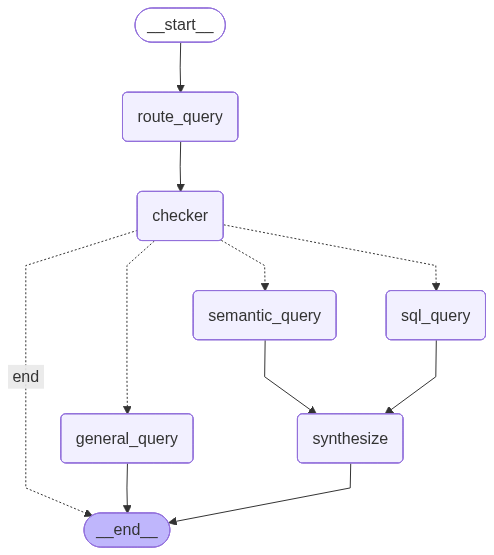

In [53]:
chatbot